In [2]:
!pip install numpy pandas scikit-learn matplotlib seaborn umap-learn

# Start with processed data

In [26]:
import pandas as pd
data = pd.read_csv("data.csv")

# Code to drop identifier columns, Drop highly correlated columns
# Detecting categorical variables, Ordinal encoding
# Drop the OLD Target Column loan_status, Convert Boolean Text Columns → Binary
# Detect numerical columns and apply scaling, Create the baseline dataset (no noise)
# Train/test split, Scaling

In [27]:
# ------------------------------------------------
# STEP 1 — DROP IDENTIFIER COLUMNS
# ------------------------------------------------

identifier_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("Identifier columns:", identifier_cols)

data = data.drop(columns=identifier_cols)
#print("Shape after dropping identifiers:", data.shape)

# ------------------------------------------------
# STEP 2 — REMOVE HIGHLY CORRELATED NUMERIC COLUMNS
# ------------------------------------------------

import numpy as np

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()

corr_matrix = data[numeric_cols].corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]

#print("Correlated columns to drop:", to_drop_corr)

data = data.drop(columns=to_drop_corr)
#print("Shape after dropping correlated columns:", data.shape)

# ------------------------------------------------
# STEP 3 — DETECT CATEGORICAL COLUMNS
# ------------------------------------------------

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# exclude target column if it still exists
if "loan_status" in categorical_cols:
    categorical_cols.remove("loan_status")

#print("Categorical columns:", categorical_cols)

# ------------------------------------------------
# STEP 4 — ORDINAL ENCODING OF CATEGORICAL VARIABLES
# ------------------------------------------------

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

data[categorical_cols] = enc.fit_transform(data[categorical_cols])

#print("Shape after encoding:", data.shape)
#data.head()

# ------------------------------------------------
# STEP 5 — DROP OLD TEXT TARGET COLUMN
# ------------------------------------------------

if "loan_status" in data.columns:
    data = data.drop(columns=["loan_status"])

#print("Dropped loan_status.")
#print("Current shape:", data.shape)

# ------------------------------------------------
# STEP 6 — BOOLEAN TO BINARY CONVERSION
# ------------------------------------------------

bool_like_cols = []

for col in data.columns:
    unique_vals = set(str(v).lower() for v in data[col].dropna().unique())
    if unique_vals.issubset({"true","false","t","f","yes","no","y","n"}):
        bool_like_cols.append(col)

#print("Boolean-like columns:", bool_like_cols)

# Convert to 0/1
for col in bool_like_cols:
    data[col] = data[col].astype(str).str.lower().map({
        "true":1,"t":1,"yes":1,"y":1,
        "false":0,"f":0,"no":0,"n":0
    }).astype(int)

#print("Boolean conversion complete.")

# ------------------------------------------------
# STEP 7 — SCALING NUMERIC COLUMNS
# ------------------------------------------------

from sklearn.preprocessing import StandardScaler

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()

# remove target if already present
if "default_binary" in numeric_cols:
    numeric_cols.remove("default_binary")

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print("Scaling complete. Shape:", data.shape)

# ------------------------------------------------
# STEP 8 — CREATE BASELINE NO-NOISE DATASET
# ------------------------------------------------

noerror_data = data.copy()
print("Baseline dataset created.")
print(noerror_data.shape)

# ------------------------------------------------
# TRAIN/TEST SPLIT (NO-NOISE DATASET)
# ------------------------------------------------

from sklearn.model_selection import train_test_split

X = noerror_data.drop(columns=["default_binary"])
y = noerror_data["default_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# ------------------------------------------------
# STEP 9 — SCALING
# ------------------------------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaling complete.")

# ------------------------------------------------
# STEP 10 — LOW VARIANCE FEATURE REMOVAL
# ------------------------------------------------

from sklearn.feature_selection import VarianceThreshold

# REMOVE ZERO-VARIANCE FEATURES ONLY
vt = VarianceThreshold(threshold=0.20)

X_train_vt = vt.fit_transform(X_train_scaled)
X_test_vt  = vt.transform(X_test_scaled)

print("After removing low-variance features:", X_train_vt.shape)

# ------------------------------------------------
# STEP 11 — PCA REDUCTION
# ------------------------------------------------

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9999)
X_train_pca = pca.fit_transform(X_train_vt)
X_test_pca  = pca.transform(X_test_vt)

print("After PCA shape:", X_train_pca.shape)

Identifier columns: []
Scaling complete. Shape: (10000, 76)
Baseline dataset created.
(10000, 76)
Train: (7500, 75) Test: (2500, 75)
Scaling complete.
After removing low-variance features: (7500, 72)
After PCA shape: (7500, 71)


# Fit the Baseline KNN Model

In [28]:
# ------------------------------------------------
# BASELINE KNN MODEL (MANHATTAN DISTANCE)
# ------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier

best_k = 78  # from your elbow curve
knn = KNeighborsClassifier(
    n_neighbors=best_k,
    metric='manhattan',
    weights='uniform'   # try 'distance' later
)

knn.fit(X_train_pca, y_train)

results = {
    "baseline_knn": {}
}

print("Baseline KNN trained with Manhattan distance.")

Baseline KNN trained with Manhattan distance.


# Evaluation 1: Accuracy

In [29]:
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

results["baseline_knn"]["accuracy"] = acc
print("Baseline Manhattan KNN Accuracy:", acc)

Baseline Manhattan KNN Accuracy: 0.838


# Evaluation 2: Confusion Matrix

In [30]:
# ------------------------------------------------
# EVALUATION 2 — CONFUSION MATRIX
# ------------------------------------------------

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

results["baseline_knn"]["confusion_matrix"] = cm

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 968  282]
 [ 123 1127]]


# Evaluation 3: Precision / Recall / F1

In [31]:
# ------------------------------------------------
# EVALUATION 3 — PRECISION / RECALL / F1
# ------------------------------------------------

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

results["baseline_knn"]["precision"] = precision
results["baseline_knn"]["recall"]    = recall
results["baseline_knn"]["f1"]        = f1

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.7998580553584103
Recall: 0.9016
F1 Score: 0.8476871004136893


# Evaluation 4: ROC-AUC Score

ROC-AUC: 0.9287411200000001


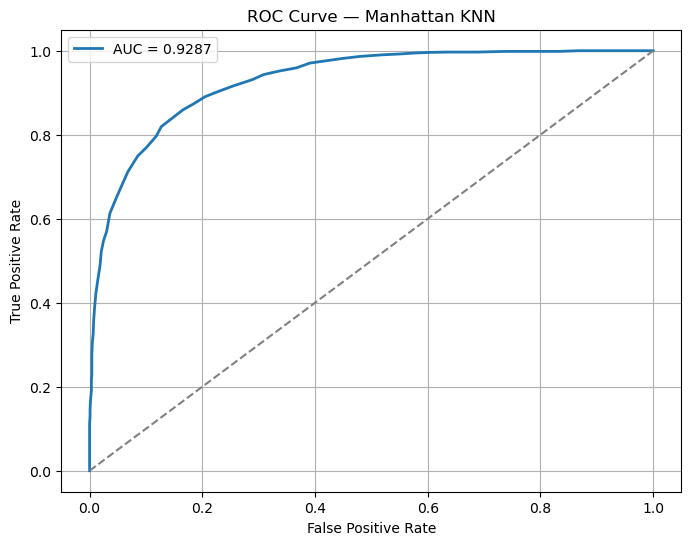

In [32]:
# ------------------------------------------------
# EVALUATION 4 — ROC-AUC (CORRECTED)
# ------------------------------------------------

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# IMPORTANT: Use PCA-transformed test data
y_prob = knn.predict_proba(X_test_pca)[:, 1]

# Compute ROC-AUC score
auc = roc_auc_score(y_test, y_prob)
results["baseline_knn"]["roc_auc"] = auc

print("ROC-AUC:", auc)

# ------------------------------------------------
# ROC CURVE PLOT
# ------------------------------------------------

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Manhattan KNN")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation 5: Calibration Curve

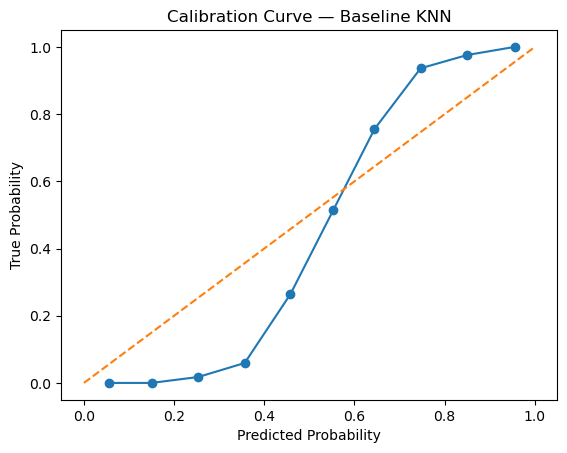

In [33]:
# ------------------------------------------------
# EVALUATION 5 — CALIBRATION CURVE
# ------------------------------------------------

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

results["baseline_knn"]["calibration_curve"] = {
    "prob_true": prob_true,
    "prob_pred": prob_pred
}

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve — Baseline KNN")
plt.show()

## Elbow Curve for the best k value

Completed Manhattan KNN training for K = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


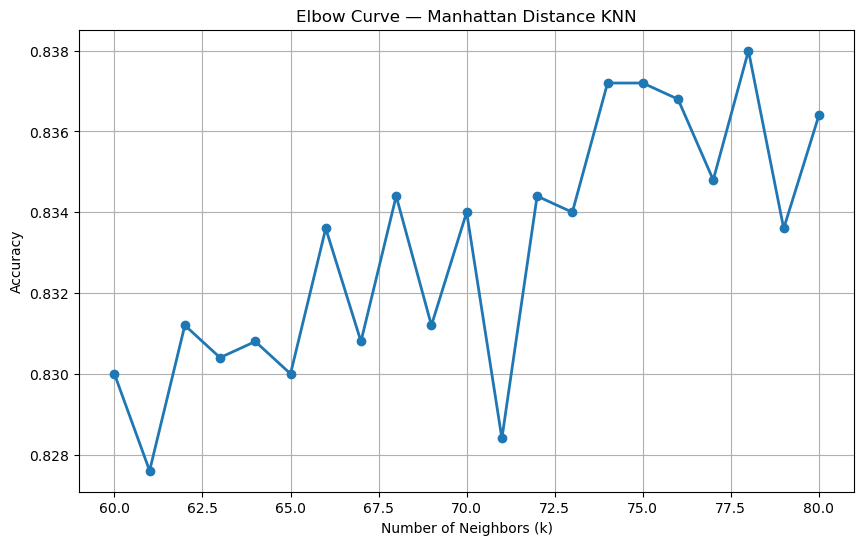

{60: {'accuracy': 0.83},
 61: {'accuracy': 0.8276},
 62: {'accuracy': 0.8312},
 63: {'accuracy': 0.8304},
 64: {'accuracy': 0.8308},
 65: {'accuracy': 0.83},
 66: {'accuracy': 0.8336},
 67: {'accuracy': 0.8308},
 68: {'accuracy': 0.8344},
 69: {'accuracy': 0.8312},
 70: {'accuracy': 0.834},
 71: {'accuracy': 0.8284},
 72: {'accuracy': 0.8344},
 73: {'accuracy': 0.834},
 74: {'accuracy': 0.8372},
 75: {'accuracy': 0.8372},
 76: {'accuracy': 0.8368},
 77: {'accuracy': 0.8348},
 78: {'accuracy': 0.838},
 79: {'accuracy': 0.8336},
 80: {'accuracy': 0.8364}}

In [35]:
# ------------------------------------------------
# ELBOW CURVE FOR MANHATTAN KNN
# ------------------------------------------------

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# --------------------------------------
# Adjustable K-range
# --------------------------------------
start_k = 60
end_k   = 80  # inclusive
k_values = list(range(start_k, end_k + 1))

accuracy_list = []
results_knn_range = {}

# --------------------------------------
# Train & Evaluate KNN for each k
# --------------------------------------
for k in k_values:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric='manhattan',
        weights = 'uniform'
    )
    
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)

    accuracy_list.append(acc)
    results_knn_range[k] = {"accuracy": acc}

print("Completed Manhattan KNN training for K =", k_values)

# --------------------------------------
# Plot elbow curve
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_list, marker='o', linewidth=2)
plt.title("Elbow Curve — Manhattan Distance KNN")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Display results
results_knn_range

# Noise 1

In [37]:
import numpy as np

def inject_symmetric_noise(y, noise_rate, random_state=42):
    """
    Flips a fraction `noise_rate` of 0->1 and 1->0 labels (symmetric noise).
    Only flips TRUE labels, not predictions.
    """
    np.random.seed(random_state)
    
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    
    # Randomly choose which indices to flip
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    
    # Flip labels: 0->1 and 1->0
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    
    return y_noisy


# Choose noise level p
p = 0.50   # 10% symmetric noise (example)

y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)
print("Original label distribution:", np.bincount(y_train))
print("Noisy label distribution:", np.bincount(y_train_noisy))

#-------------------------------------------------------------------------------------------------------------------
knn_noisy = KNeighborsClassifier(
    n_neighbors=best_k,    # your chosen best K (e.g., 78)
    metric='manhattan'
)

knn_noisy.fit(X_train_pca, y_train_noisy)

y_pred_noisy = knn_noisy.predict(X_test_pca)
y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]
#-------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

acc_noisy = accuracy_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
f1_noisy  = f1_score(y_test, y_pred_noisy)

print(f"Accuracy with p={p}: {acc_noisy}")
print(f"AUC with p={p}: {auc_noisy}")
print(f"F1 Score with p={p}: {f1_noisy}")
#-------------------------------------------------------------------------------------------------------------------
if "noise_results" not in results:
    results["noise_results"] = {}

results["noise_results"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "auc": auc_noisy,
    "f1": f1_noisy
}

Original label distribution: [3750 3750]
Noisy label distribution: [3826 3674]
Accuracy with p=0.5: 0.5152
AUC with p=0.5: 0.5457785599999999
F1 Score with p=0.5: 0.42395437262357416



=== Noise level p = 0.05 ===
Accuracy:  0.8300
Precision: 0.7835
Recall:    0.9120
F1 Score:  0.8429
AUC:       0.9251

=== Noise level p = 0.10 ===
Accuracy:  0.8276
Precision: 0.7826
Recall:    0.9072
F1 Score:  0.8403
AUC:       0.9243

=== Noise level p = 0.15 ===
Accuracy:  0.8296
Precision: 0.7869
Recall:    0.9040
F1 Score:  0.8414
AUC:       0.9203

=== Noise level p = 0.20 ===
Accuracy:  0.8284
Precision: 0.7829
Recall:    0.9088
F1 Score:  0.8412
AUC:       0.9159

=== Noise level p = 0.25 ===
Accuracy:  0.8180
Precision: 0.7747
Recall:    0.8968
F1 Score:  0.8313
AUC:       0.9042

=== Noise level p = 0.30 ===
Accuracy:  0.7944
Precision: 0.7563
Recall:    0.8688
F1 Score:  0.8086
AUC:       0.8861

=== Noise level p = 0.35 ===
Accuracy:  0.7788
Precision: 0.7498
Recall:    0.8368
F1 Score:  0.7909
AUC:       0.8566

=== Noise level p = 0.40 ===
Accuracy:  0.7152
Precision: 0.7253
Recall:    0.6928
F1 Score:  0.7087
AUC:       0.7952

=== Noise level p = 0.45 ===
Accuracy: 

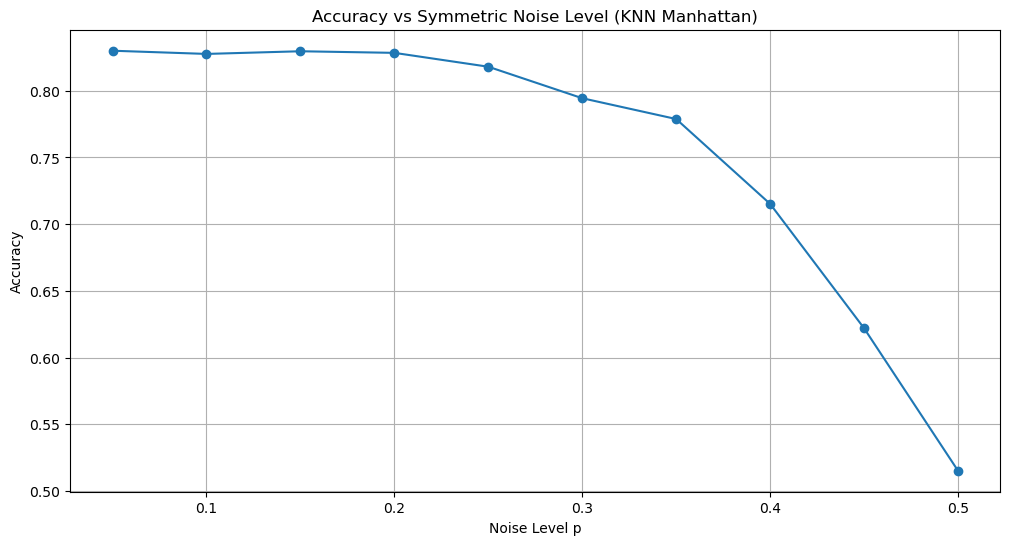

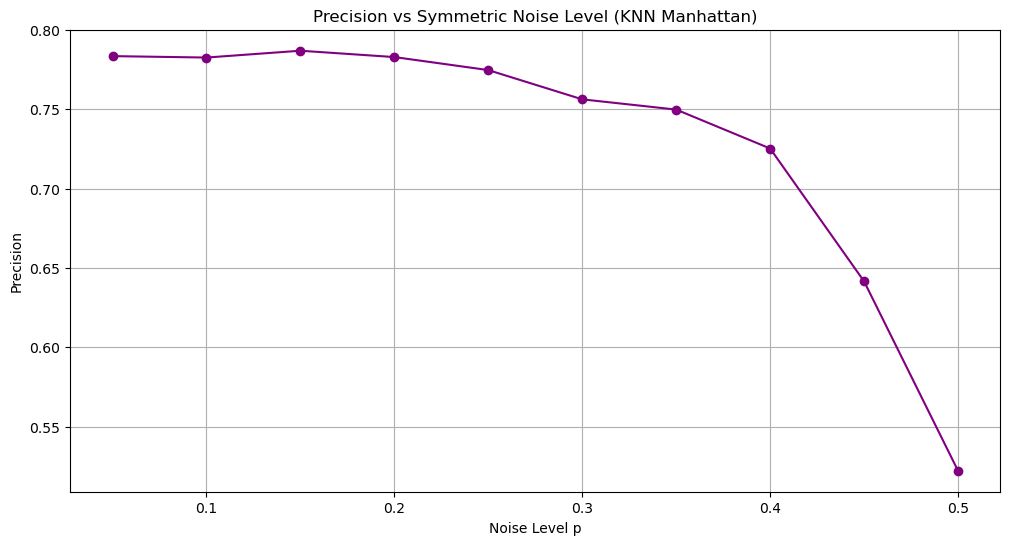

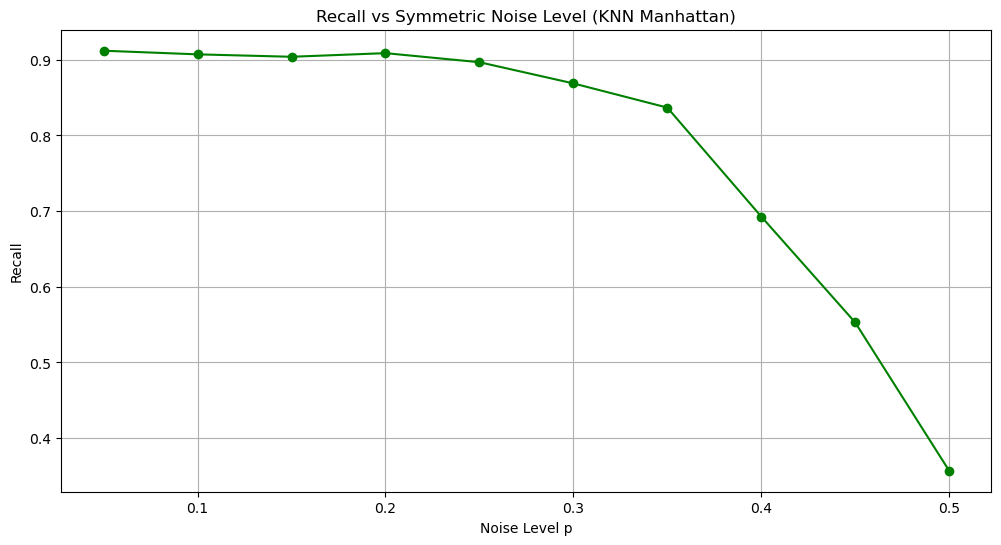

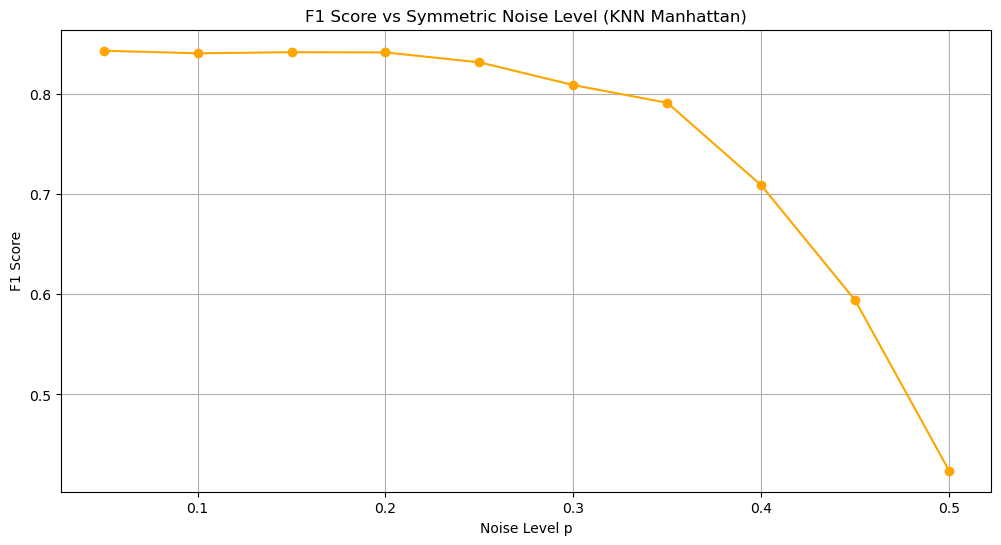

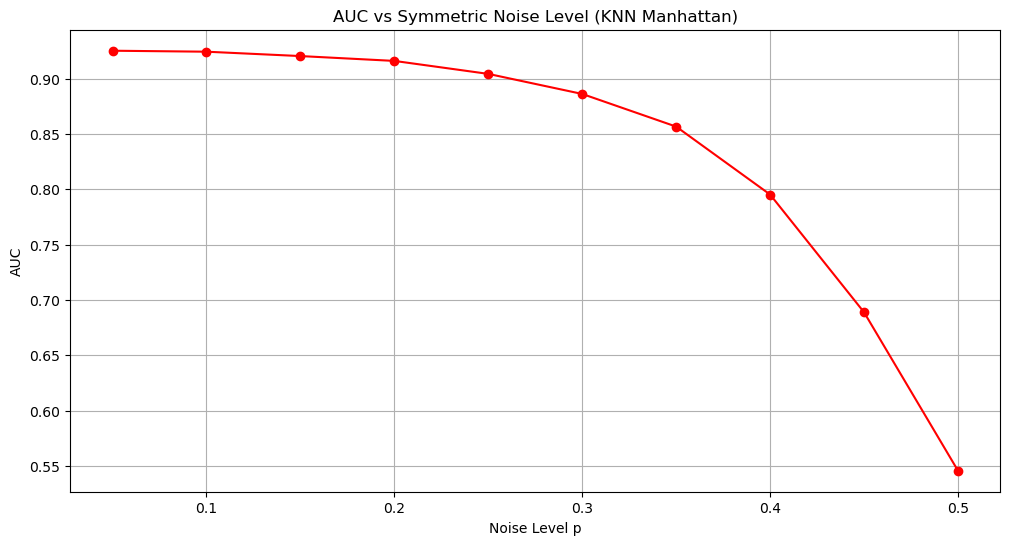

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------------------------------------
# Noise injection function (already defined by you)
# -----------------------------------------------------------
def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy


# -----------------------------------------------------------
# Define noise levels
# -----------------------------------------------------------
noise_levels = np.arange(0.05, 0.55, 0.05)   # 0.05 ... 0.50


# -----------------------------------------------------------
# Storage for results
# -----------------------------------------------------------
acc_list = []
prec_list = []
rec_list = []
f1_list = []
auc_list = []


# -----------------------------------------------------------
# Run experiment across all noise levels
# -----------------------------------------------------------
for p in noise_levels:
    print(f"\n=== Noise level p = {p:.2f} ===")
    
    # Inject noise in TRAIN labels only
    y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)

    # Train KNN with MANHATTAN distance
    knn_noisy = KNeighborsClassifier(
        n_neighbors=best_k,
        metric='manhattan'
    )
    knn_noisy.fit(X_train_pca, y_train_noisy)

    # Predictions
    y_pred_noisy = knn_noisy.predict(X_test_pca)
    y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred_noisy)
    prec = precision_score(y_test, y_pred_noisy)
    rec = recall_score(y_test, y_pred_noisy)
    f1 = f1_score(y_test, y_pred_noisy)
    auc = roc_auc_score(y_test, y_prob_noisy)

    # Save results
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    auc_list.append(auc)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")


# -----------------------------------------------------------
# PLOTS
# -----------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(noise_levels, acc_list, marker='o')
plt.title("Accuracy vs Symmetric Noise Level (KNN Manhattan)")
plt.xlabel("Noise Level p")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(noise_levels, prec_list, marker='o', color='purple')
plt.title("Precision vs Symmetric Noise Level (KNN Manhattan)")
plt.xlabel("Noise Level p")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(noise_levels, rec_list, marker='o', color='green')
plt.title("Recall vs Symmetric Noise Level (KNN Manhattan)")
plt.xlabel("Noise Level p")
plt.ylabel("Recall")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(noise_levels, f1_list, marker='o', color='orange')
plt.title("F1 Score vs Symmetric Noise Level (KNN Manhattan)")
plt.xlabel("Noise Level p")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(noise_levels, auc_list, marker='o', color='red')
plt.title("AUC vs Symmetric Noise Level (KNN Manhattan)")
plt.xlabel("Noise Level p")
plt.ylabel("AUC")
plt.grid(True)
plt.show()


=== Noise level p = 0.05 ===
Accuracy:  0.8300 | AUC: 0.9251 | F1: 0.8429
Precision: 0.7835 | Recall: 0.9120
Log-loss:  0.4641 | Brier: 0.1465 | ECE: 0.1670
Balanced Acc: 0.8300 | MCC: 0.6691 | Kappa: 0.6600
TP=1140, TN=935, FP=315, FN=110

=== Noise level p = 0.10 ===
Accuracy:  0.8276 | AUC: 0.9243 | F1: 0.8403
Precision: 0.7826 | Recall: 0.9072
Log-loss:  0.4853 | Brier: 0.1541 | ECE: 0.1801
Balanced Acc: 0.8276 | MCC: 0.6637 | Kappa: 0.6552
TP=1134, TN=935, FP=315, FN=116

=== Noise level p = 0.15 ===
Accuracy:  0.8296 | AUC: 0.9203 | F1: 0.8414
Precision: 0.7869 | Recall: 0.9040
Log-loss:  0.5072 | Brier: 0.1627 | ECE: 0.1921
Balanced Acc: 0.8296 | MCC: 0.6666 | Kappa: 0.6592
TP=1130, TN=944, FP=306, FN=120

=== Noise level p = 0.20 ===
Accuracy:  0.8284 | AUC: 0.9159 | F1: 0.8412
Precision: 0.7829 | Recall: 0.9088
Log-loss:  0.5295 | Brier: 0.1722 | ECE: 0.1936
Balanced Acc: 0.8284 | MCC: 0.6655 | Kappa: 0.6568
TP=1136, TN=935, FP=315, FN=114

=== Noise level p = 0.25 ===
Accura

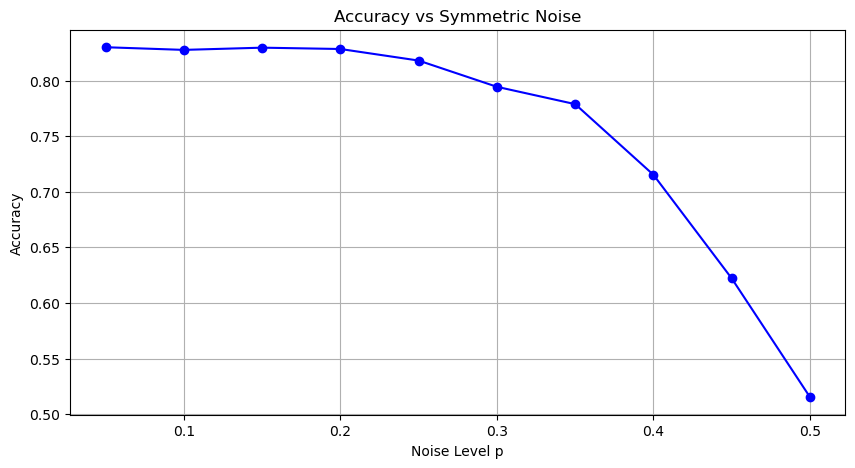

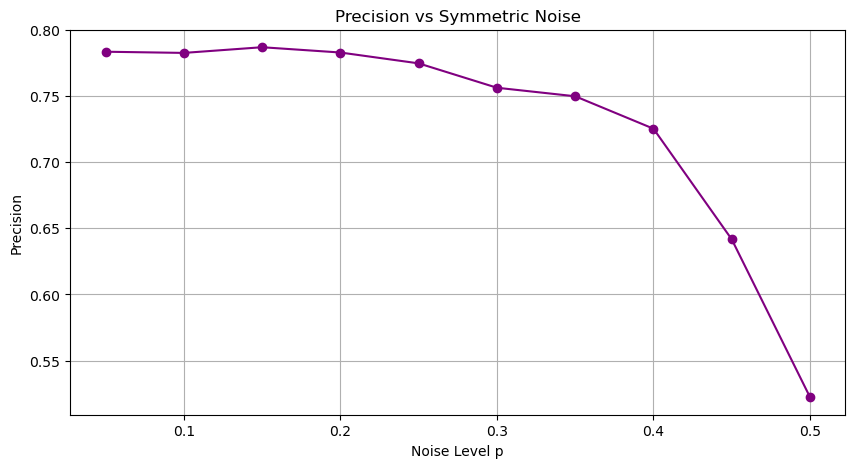

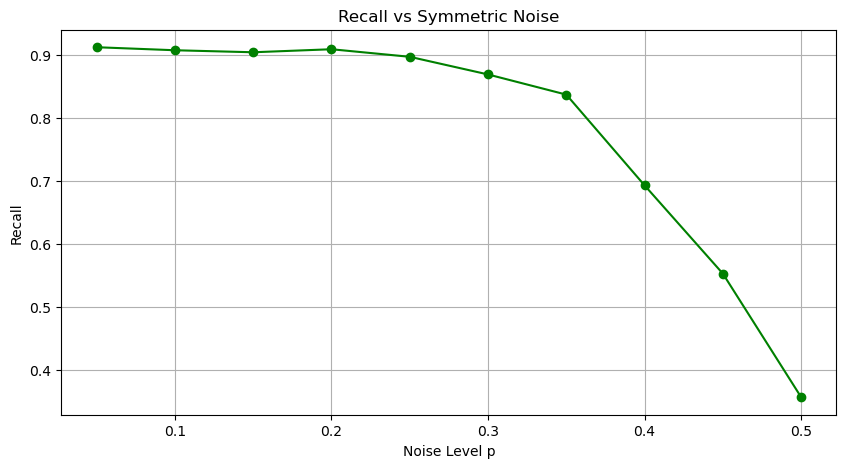

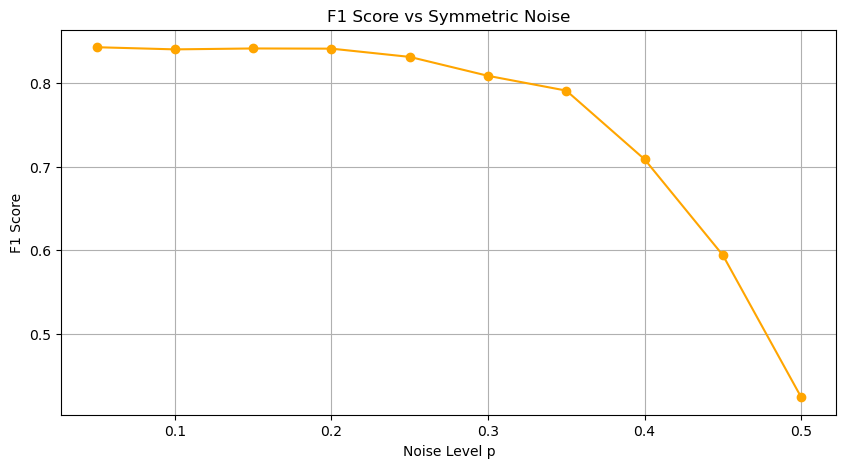

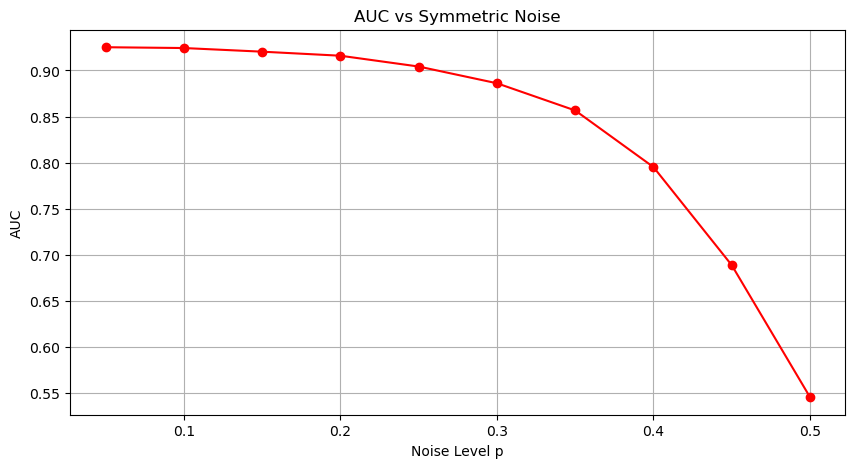

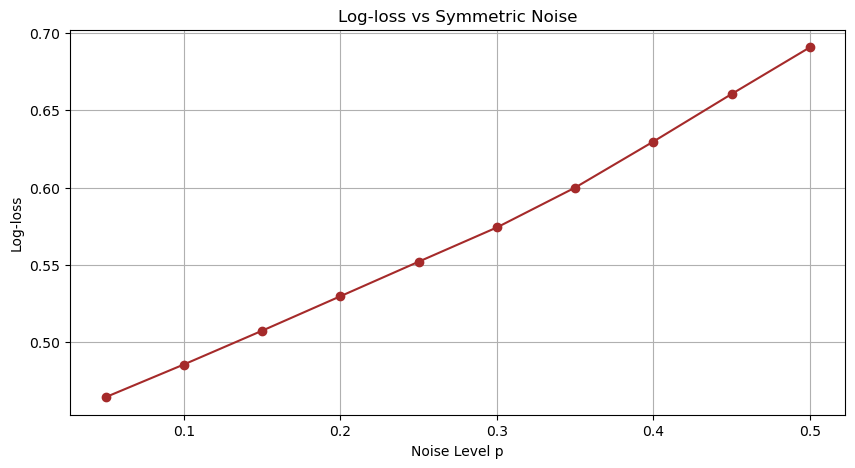

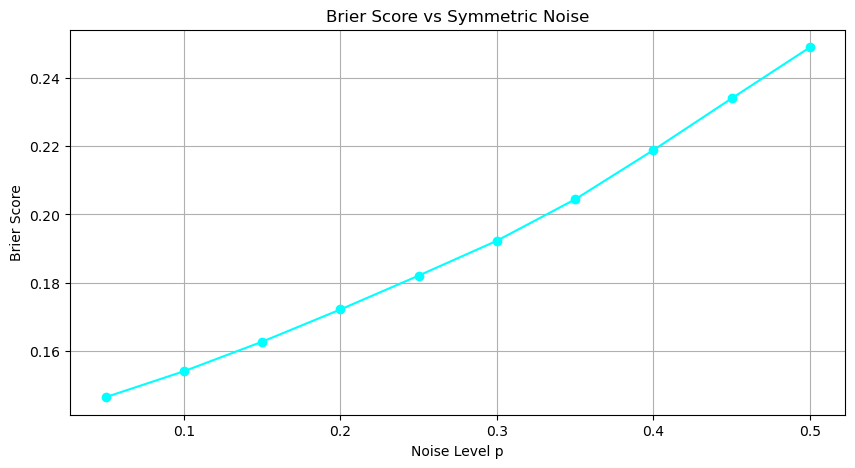

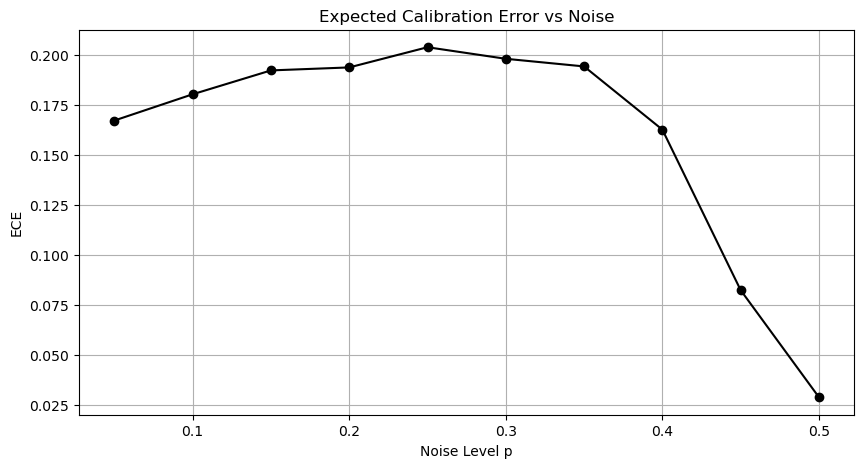

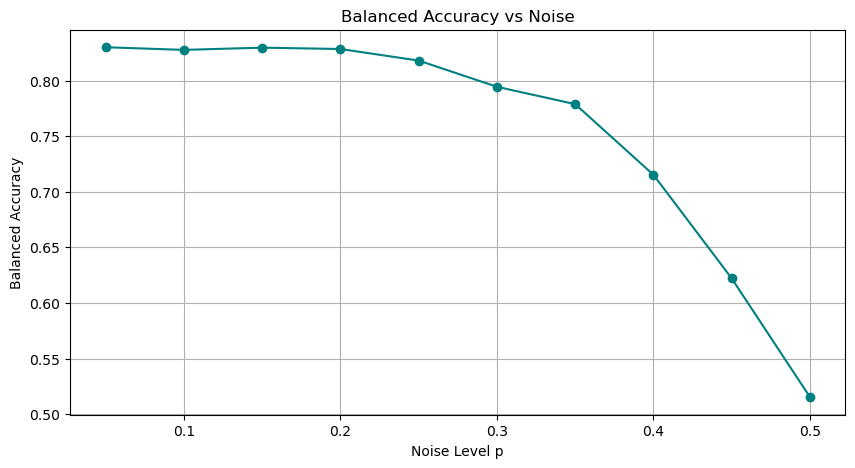

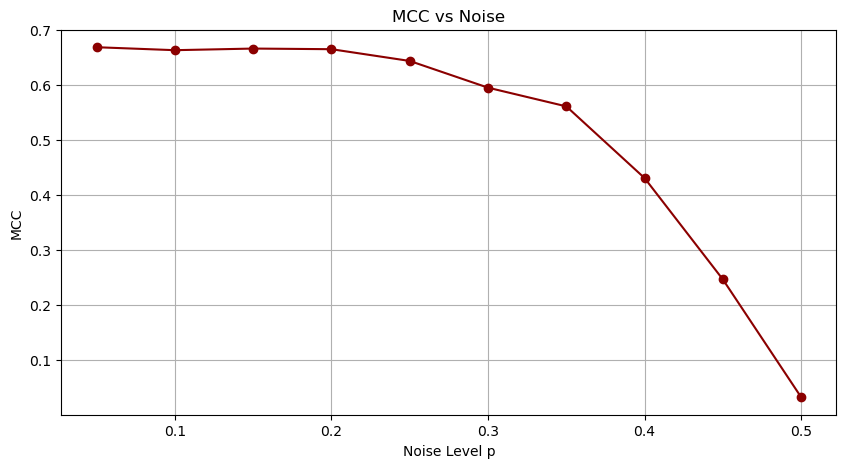

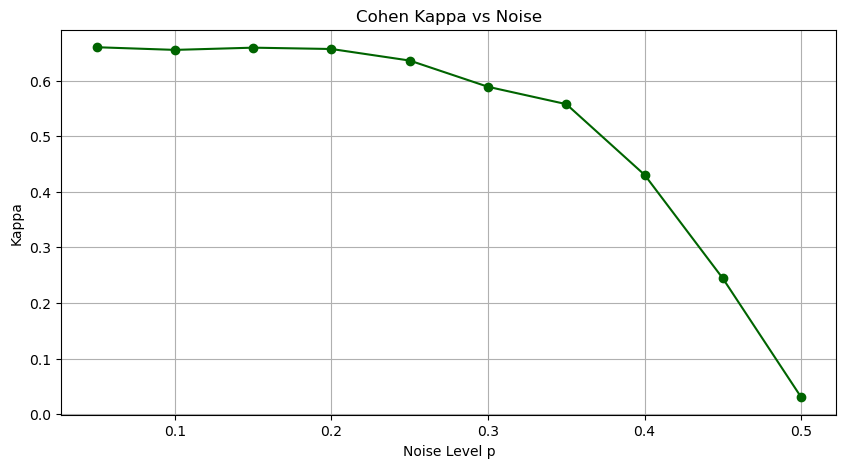

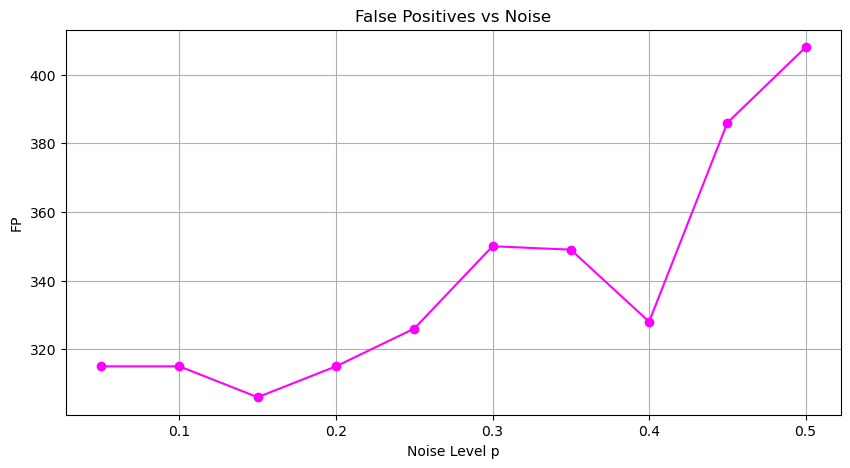

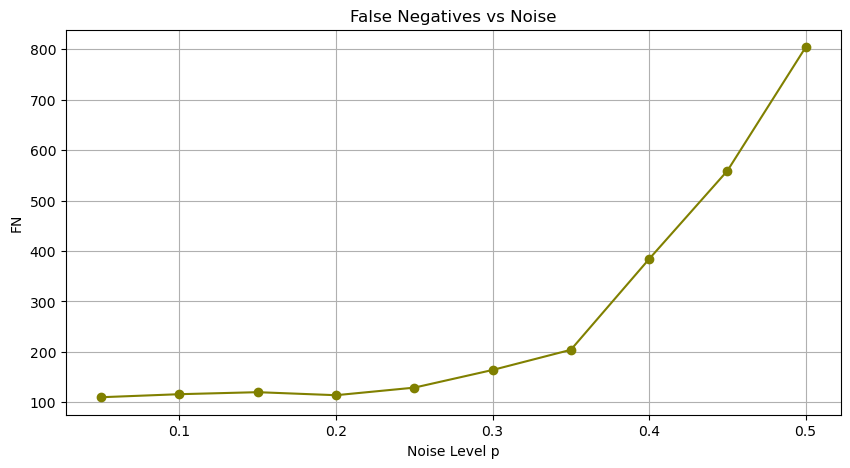

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    confusion_matrix
)
from sklearn.neighbors import KNeighborsClassifier


# -----------------------------------------------------------
# Expected Calibration Error (ECE)
# -----------------------------------------------------------
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0
    for i in range(n_bins):
        idx = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.sum(idx) > 0:
            avg_conf = y_prob[idx].mean()
            avg_acc  = y_true[idx].mean()
            ece += (np.sum(idx) / len(y_prob)) * abs(avg_conf - avg_acc)
    return ece


# -----------------------------------------------------------
# Noise levels 0.05 to 0.50
# -----------------------------------------------------------
noise_levels = np.arange(0.05, 0.55, 0.05)


# -----------------------------------------------------------
# Storage for ALL metrics
# -----------------------------------------------------------
acc_list = []
prec_list = []
rec_list = []
f1_list = []
auc_list = []

logloss_list = []
brier_list = []
ece_list = []

bal_acc_list = []
mcc_list = []
kappa_list = []

tp_list = []
tn_list = []
fp_list = []
fn_list = []


# -----------------------------------------------------------
# MAIN LOOP
# -----------------------------------------------------------
for p in noise_levels:
    print(f"\n=== Noise level p = {p:.2f} ===")

    # Inject symmetric label noise into TRAIN ONLY
    y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)

    # Train Manhattan KNN
    knn_noisy = KNeighborsClassifier(
        n_neighbors=best_k,
        metric='manhattan'
    )
    knn_noisy.fit(X_train_pca, y_train_noisy)

    # Predictions
    y_pred_noisy = knn_noisy.predict(X_test_pca)
    y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

    # -------------------------------------------------------
    # Compute metrics
    # -------------------------------------------------------
    acc = accuracy_score(y_test, y_pred_noisy)
    prec = precision_score(y_test, y_pred_noisy)
    rec = recall_score(y_test, y_pred_noisy)
    f1 = f1_score(y_test, y_pred_noisy)
    auc = roc_auc_score(y_test, y_prob_noisy)

    ll = log_loss(y_test, y_prob_noisy)
    brier = brier_score_loss(y_test, y_prob_noisy)
    ece = compute_ece(y_test, y_prob_noisy)

    bal_acc = balanced_accuracy_score(y_test, y_pred_noisy)
    mcc = matthews_corrcoef(y_test, y_pred_noisy)
    kappa = cohen_kappa_score(y_test, y_pred_noisy)

    cm = confusion_matrix(y_test, y_pred_noisy)
    tn, fp, fn, tp = cm.ravel()

    # -------------------------------------------------------
    # Save all metrics
    # -------------------------------------------------------
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    auc_list.append(auc)

    logloss_list.append(ll)
    brier_list.append(brier)
    ece_list.append(ece)

    bal_acc_list.append(bal_acc)
    mcc_list.append(mcc)
    kappa_list.append(kappa)

    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)

    print(f"Accuracy:  {acc:.4f} | AUC: {auc:.4f} | F1: {f1:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f}")
    print(f"Log-loss:  {ll:.4f} | Brier: {brier:.4f} | ECE: {ece:.4f}")
    print(f"Balanced Acc: {bal_acc:.4f} | MCC: {mcc:.4f} | Kappa: {kappa:.4f}")
    print(f"TP={tp}, TN={tn}, FP={fp}, FN={fn}")


# -----------------------------------------------------------
# PLOTS FOR ALL METRICS
# -----------------------------------------------------------
def plot_metric(noise_levels, metric_values, title, ylabel, color="blue"):
    plt.figure(figsize=(10, 5))
    plt.plot(noise_levels, metric_values, marker='o', color=color)
    plt.title(title)
    plt.xlabel("Noise Level p")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Basic metrics
plot_metric(noise_levels, acc_list, "Accuracy vs Symmetric Noise", "Accuracy")
plot_metric(noise_levels, prec_list, "Precision vs Symmetric Noise", "Precision", "purple")
plot_metric(noise_levels, rec_list, "Recall vs Symmetric Noise", "Recall", "green")
plot_metric(noise_levels, f1_list, "F1 Score vs Symmetric Noise", "F1 Score", "orange")
plot_metric(noise_levels, auc_list, "AUC vs Symmetric Noise", "AUC", "red")

# Calibration metrics
plot_metric(noise_levels, logloss_list, "Log-loss vs Symmetric Noise", "Log-loss", "brown")
plot_metric(noise_levels, brier_list, "Brier Score vs Symmetric Noise", "Brier Score", "cyan")
plot_metric(noise_levels, ece_list, "Expected Calibration Error vs Noise", "ECE", "black")

# Robustness & agreement metrics
plot_metric(noise_levels, bal_acc_list, "Balanced Accuracy vs Noise", "Balanced Accuracy", "teal")
plot_metric(noise_levels, mcc_list, "MCC vs Noise", "MCC", "darkred")
plot_metric(noise_levels, kappa_list, "Cohen Kappa vs Noise", "Kappa", "darkgreen")

# Confusion matrix drift (FP and FN)
plot_metric(noise_levels, fp_list, "False Positives vs Noise", "FP", "magenta")
plot_metric(noise_levels, fn_list, "False Negatives vs Noise", "FN", "olive")

# Noise 2: Asymmetric Noise


=== Asymmetric Noise: Flip class 0 at rate p = 0.05 ===
Accuracy=0.8220 | Precision=0.7653 | Recall=0.9288 | F1=0.8392 | AUC=0.9290
LogLoss=0.4607 | Brier=0.1465 | ECE=0.1759
Balanced Acc=0.8220 | MCC=0.6592 | Kappa=0.6440
TP=1161, TN=894, FP=356, FN=89

=== Asymmetric Noise: Flip class 0 at rate p = 0.10 ===
Accuracy=0.8032 | Precision=0.7328 | Recall=0.9544 | F1=0.8290 | AUC=0.9278
LogLoss=0.4767 | Brier=0.1539 | ECE=0.1829
Balanced Acc=0.8032 | MCC=0.6362 | Kappa=0.6064
TP=1193, TN=815, FP=435, FN=57

=== Asymmetric Noise: Flip class 0 at rate p = 0.15 ===
Accuracy=0.7728 | Precision=0.6953 | Recall=0.9712 | F1=0.8104 | AUC=0.9250
LogLoss=0.4974 | Brier=0.1638 | ECE=0.1889
Balanced Acc=0.7728 | MCC=0.5944 | Kappa=0.5456
TP=1214, TN=718, FP=532, FN=36

=== Asymmetric Noise: Flip class 0 at rate p = 0.20 ===
Accuracy=0.7252 | Precision=0.6479 | Recall=0.9864 | F1=0.7821 | AUC=0.9229
LogLoss=0.5198 | Brier=0.1751 | ECE=0.2027
Balanced Acc=0.7252 | MCC=0.5282 | Kappa=0.4504
TP=1233, TN

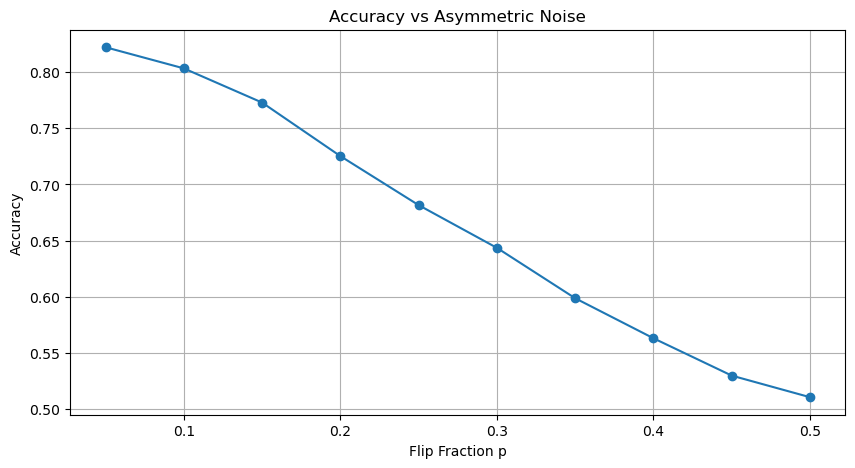

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    confusion_matrix
)

# -----------------------------------------------------------
# Asymmetric noise function
# -----------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    """
    Flips a fraction of labels from class_to_flip -> the other class.
    Example: class_to_flip=0, flip_fraction=0.3 => 30% of 0s become 1s.
    """
    np.random.seed(random_state)
    y_noisy = y.copy()
    
    # Indices of the class to be flipped
    idx = np.where(y == class_to_flip)[0]
    
    # Number to flip
    n_flip = int(len(idx) * flip_fraction)
    
    # Randomly pick samples to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    
    # Flip labels
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy


# -----------------------------------------------------------
# Choose noise direction and noise levels
# -----------------------------------------------------------
class_to_flip = 0       # flip 0 → 1 (example; can change to 1)
noise_levels = np.arange(0.05, 0.55, 0.05)   # 5% ... 50%


# -----------------------------------------------------------
# Storage for metrics
# -----------------------------------------------------------
acc_list = []
prec_list = []
rec_list = []
f1_list = []
auc_list = []

logloss_list = []
brier_list = []
ece_list = []

balacc_list = []
mcc_list = []
kappa_list = []

tp_list = []
tn_list = []
fp_list = []
fn_list = []


# -----------------------------------------------------------
# Expected Calibration Error (ECE)
# -----------------------------------------------------------
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0
    for i in range(n_bins):
        idx = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.sum(idx) > 0:
            avg_conf = y_prob[idx].mean()
            avg_acc  = y_true[idx].mean()
            ece += (np.sum(idx) / len(y_prob)) * abs(avg_conf - avg_acc)
    return ece


# -----------------------------------------------------------
# MAIN LOOP — Try all noise levels
# -----------------------------------------------------------
for p in noise_levels:
    print(f"\n=== Asymmetric Noise: Flip class {class_to_flip} at rate p = {p:.2f} ===")

    # Inject asymmetric noise into training labels ONLY
    y_train_noisy = inject_asymmetric_noise(
        y_train.values, class_to_flip=class_to_flip, flip_fraction=p
    )

    # Train Manhattan KNN
    knn_noisy = KNeighborsClassifier(
        n_neighbors=best_k,
        metric='manhattan'
    )
    knn_noisy.fit(X_train_pca, y_train_noisy)

    # Predictions
    y_pred_noisy = knn_noisy.predict(X_test_pca)
    y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred_noisy)
    prec = precision_score(y_test, y_pred_noisy)
    rec = recall_score(y_test, y_pred_noisy)
    f1 = f1_score(y_test, y_pred_noisy)
    auc = roc_auc_score(y_test, y_prob_noisy)

    ll = log_loss(y_test, y_prob_noisy)
    brier = brier_score_loss(y_test, y_prob_noisy)
    ece = compute_ece(y_test, y_prob_noisy)

    balacc = balanced_accuracy_score(y_test, y_pred_noisy)
    mcc = matthews_corrcoef(y_test, y_pred_noisy)
    kappa = cohen_kappa_score(y_test, y_pred_noisy)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_noisy).ravel()

    # Save metrics
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    auc_list.append(auc)

    logloss_list.append(ll)
    brier_list.append(brier)
    ece_list.append(ece)

    balacc_list.append(balacc)
    mcc_list.append(mcc)
    kappa_list.append(kappa)

    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)

    print(f"Accuracy={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f}")
    print(f"LogLoss={ll:.4f} | Brier={brier:.4f} | ECE={ece:.4f}")
    print(f"Balanced Acc={balacc:.4f} | MCC={mcc:.4f} | Kappa={kappa:.4f}")
    print(f"TP={tp}, TN={tn}, FP={fp}, FN={fn}")


# -----------------------------------------------------------
# PLOT EXAMPLE (You can copy your plotting code again)
# -----------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(noise_levels, acc_list, marker='o')
plt.title("Accuracy vs Asymmetric Noise")
plt.xlabel("Flip Fraction p")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

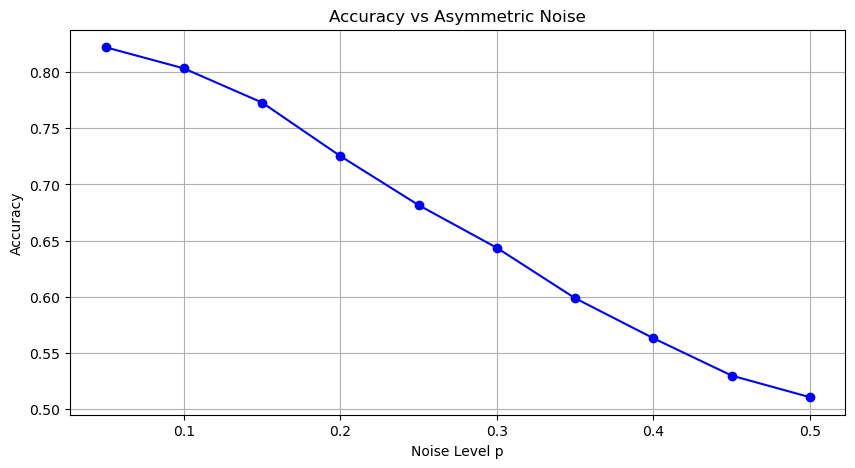

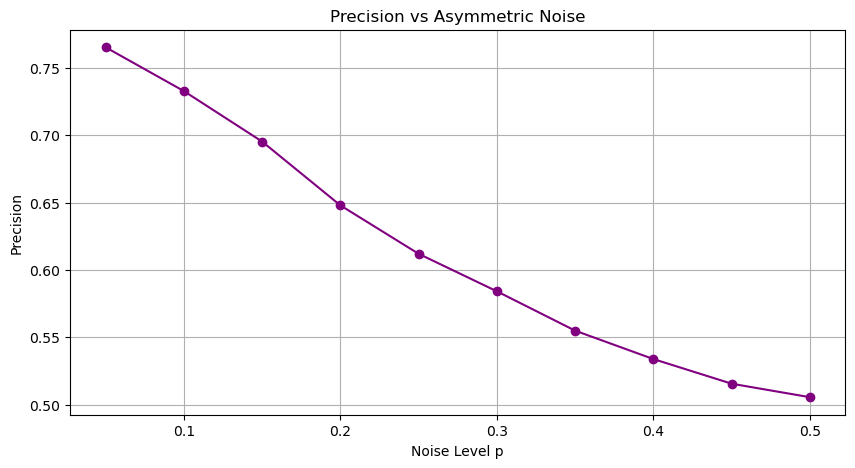

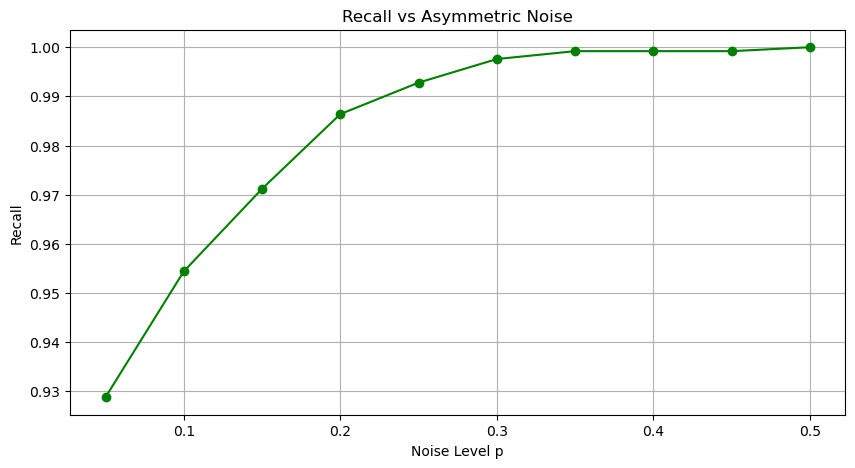

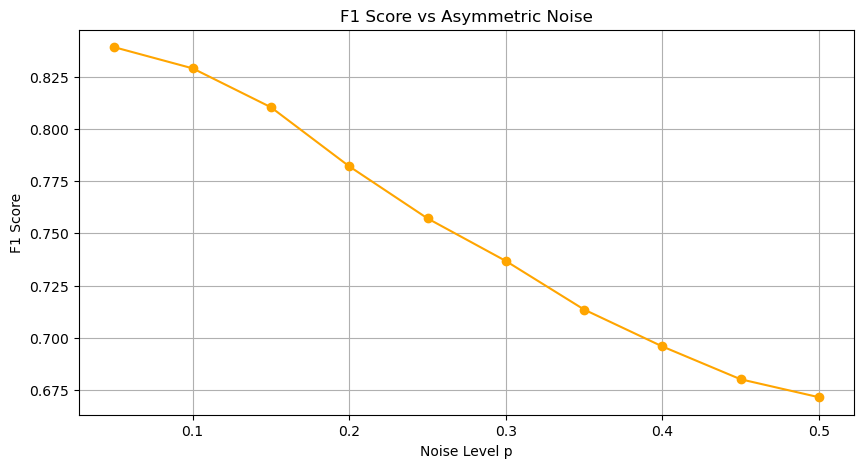

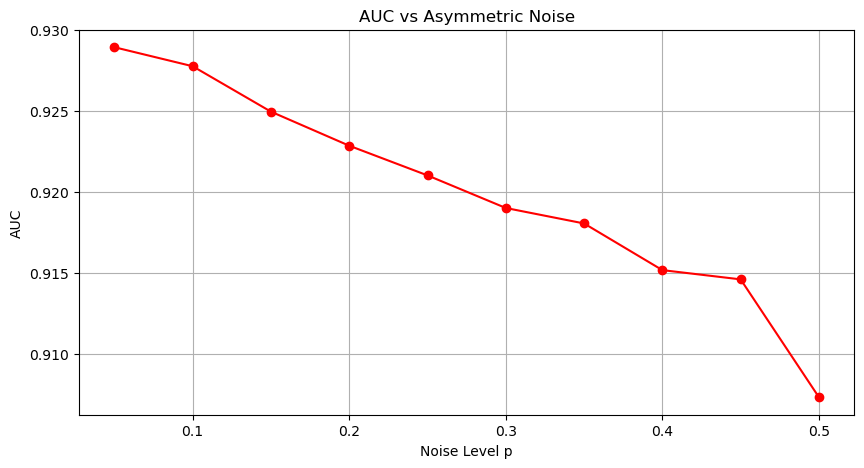

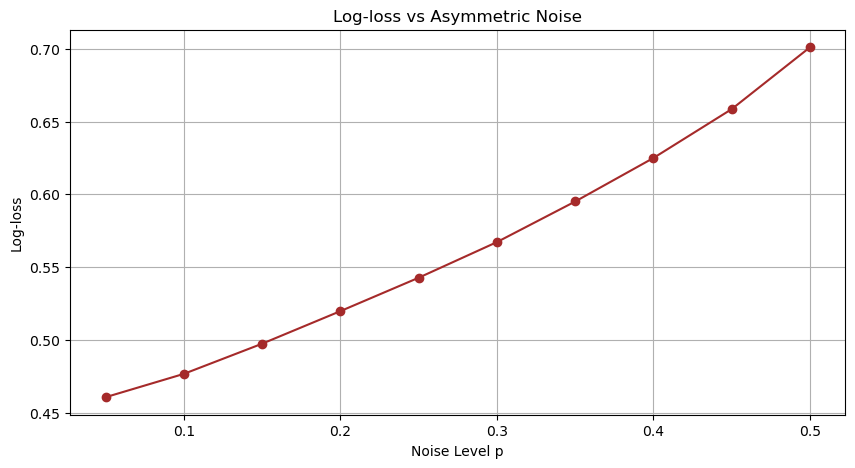

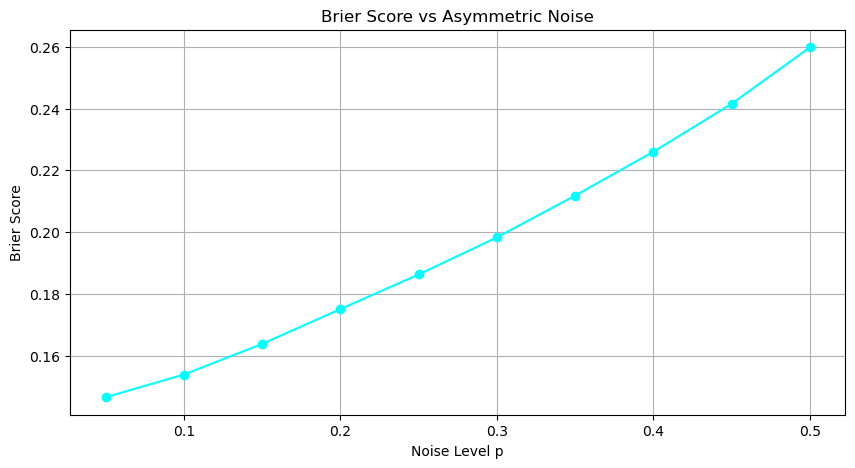

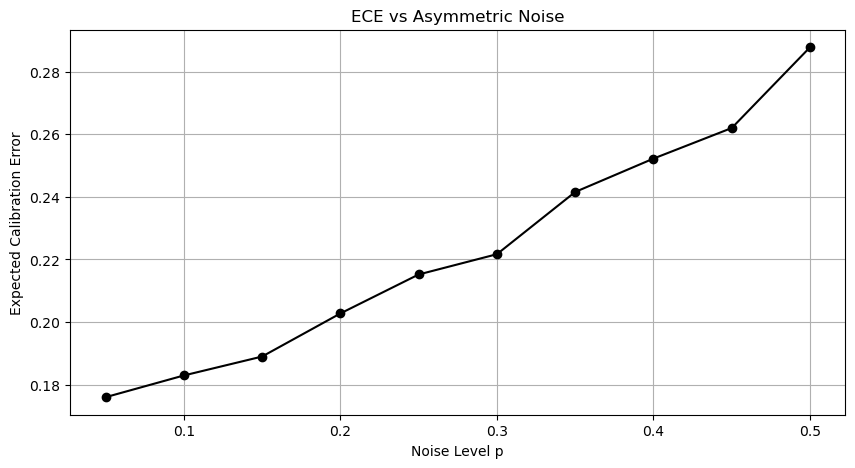

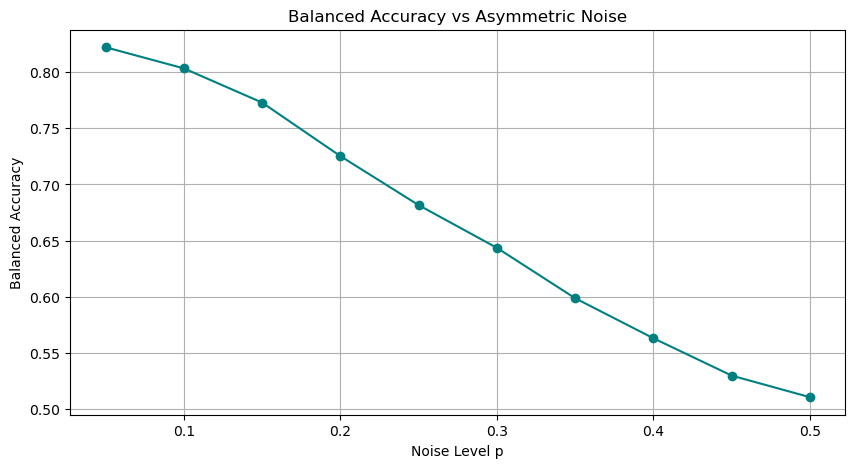

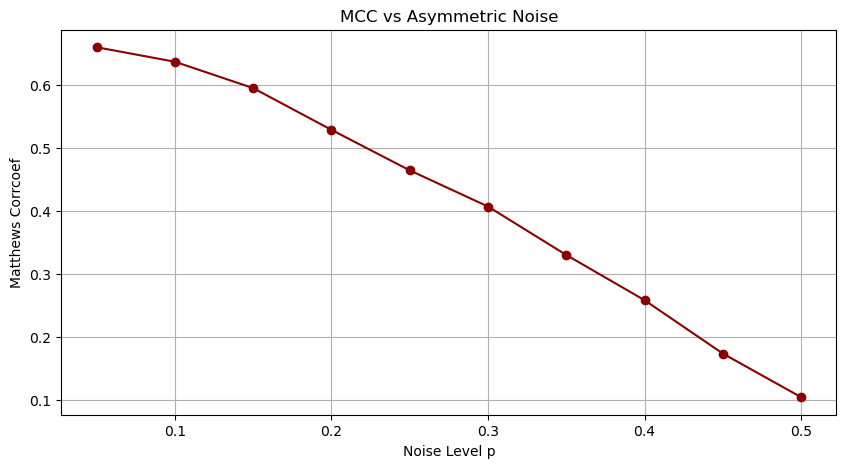

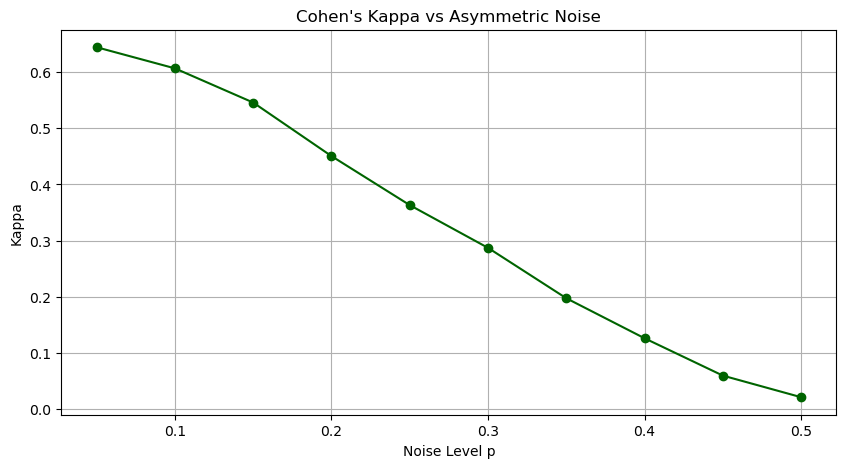

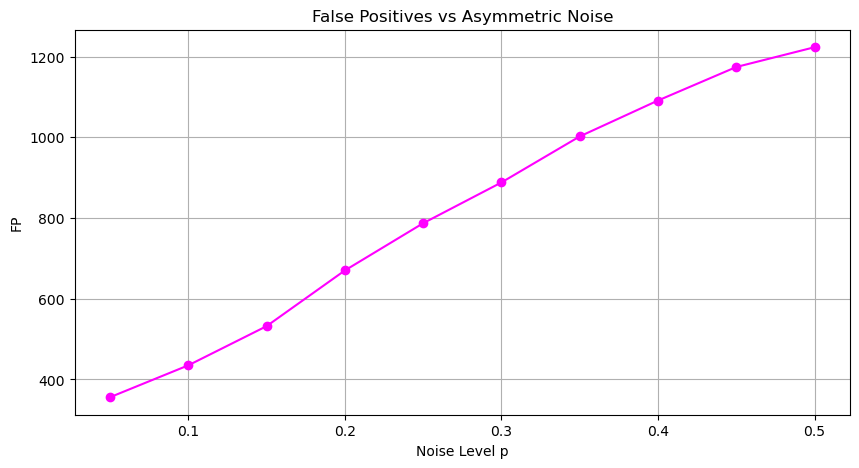

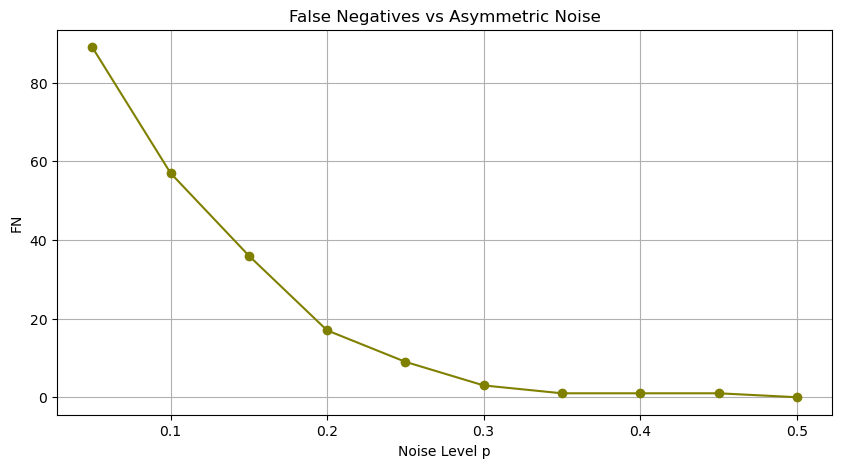

In [41]:
# ============================================
# PLOTTING ALL METRICS FOR ASYMMETRIC NOISE
# ============================================

def plot_metric(noise_levels, metric_values, title, ylabel, color="blue"):
    plt.figure(figsize=(10,5))
    plt.plot(noise_levels, metric_values, marker='o', color=color)
    plt.title(title)
    plt.xlabel("Noise Level p")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Accuracy-family metrics
plot_metric(noise_levels, acc_list,  "Accuracy vs Asymmetric Noise", "Accuracy")
plot_metric(noise_levels, prec_list, "Precision vs Asymmetric Noise", "Precision", "purple")
plot_metric(noise_levels, rec_list,  "Recall vs Asymmetric Noise", "Recall", "green")
plot_metric(noise_levels, f1_list,   "F1 Score vs Asymmetric Noise", "F1 Score", "orange")
plot_metric(noise_levels, auc_list,  "AUC vs Asymmetric Noise", "AUC", "red")

# Calibration metrics
plot_metric(noise_levels, logloss_list, "Log-loss vs Asymmetric Noise", "Log-loss", "brown")
plot_metric(noise_levels, brier_list,   "Brier Score vs Asymmetric Noise", "Brier Score", "cyan")
plot_metric(noise_levels, ece_list,     "ECE vs Asymmetric Noise", "Expected Calibration Error", "black")

# Robustness metrics
plot_metric(noise_levels, balacc_list, "Balanced Accuracy vs Asymmetric Noise", "Balanced Accuracy", "teal")
plot_metric(noise_levels, mcc_list,    "MCC vs Asymmetric Noise", "Matthews Corrcoef", "darkred")
plot_metric(noise_levels, kappa_list,  "Cohen's Kappa vs Asymmetric Noise", "Kappa", "darkgreen")

# Confusion-matrix drift
plot_metric(noise_levels, fp_list, "False Positives vs Asymmetric Noise", "FP", "magenta")
plot_metric(noise_levels, fn_list, "False Negatives vs Asymmetric Noise", "FN", "olive")


Testing flip direction: 0 → 1

p = 0.05
  Accuracy=0.8220, AUC=0.9290, F1=0.8392
p = 0.10
  Accuracy=0.8032, AUC=0.9278, F1=0.8290
p = 0.15
  Accuracy=0.7728, AUC=0.9250, F1=0.8104
p = 0.20
  Accuracy=0.7252, AUC=0.9229, F1=0.7821
p = 0.25
  Accuracy=0.6816, AUC=0.9210, F1=0.7572
p = 0.30
  Accuracy=0.6436, AUC=0.9190, F1=0.7368
p = 0.35
  Accuracy=0.5988, AUC=0.9181, F1=0.7135
p = 0.40
  Accuracy=0.5632, AUC=0.9152, F1=0.6958
p = 0.45
  Accuracy=0.5300, AUC=0.9146, F1=0.6801
p = 0.50
  Accuracy=0.5108, AUC=0.9073, F1=0.6715



Testing flip direction: 1 → 0

p = 0.05
  Accuracy=0.8480, AUC=0.9306, F1=0.8512
p = 0.10
  Accuracy=0.8396, AUC=0.9294, F1=0.8353
p = 0.15
  Accuracy=0.8376, AUC=0.9300, F1=0.8221
p = 0.20
  Accuracy=0.8096, AUC=0.9275, F1=0.7794
p = 0.25
  Accuracy=0.7584, AUC=0.9237, F1=0.6934
p = 0.30
  Accuracy=0.7036, AUC=0.9201, F1=0.5839
p = 0.35
  Accuracy=0.6472, AUC=0.9138, F1=0.4589
p = 0.40
  Accuracy=0.5872, AUC=0.9081, F1=0.2999
p = 0.45
  Accuracy=0.5480, AUC=0.

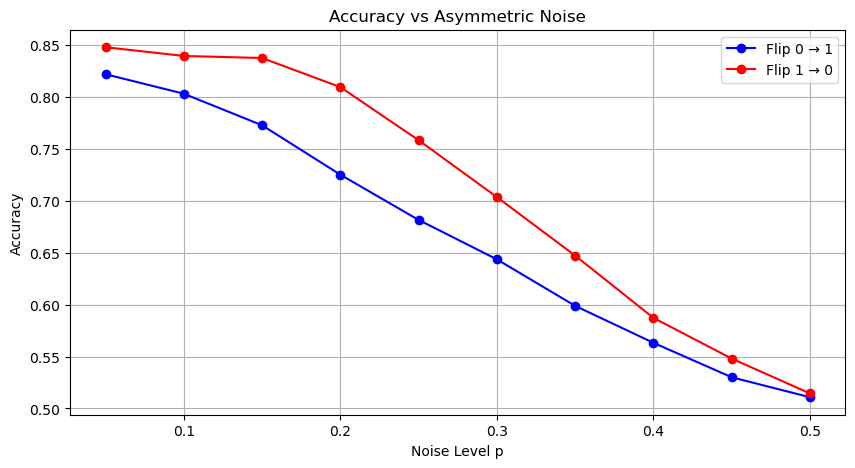

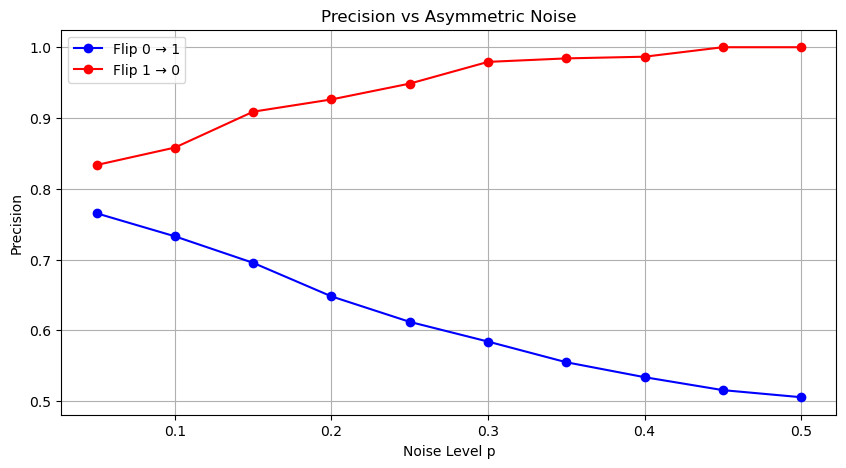

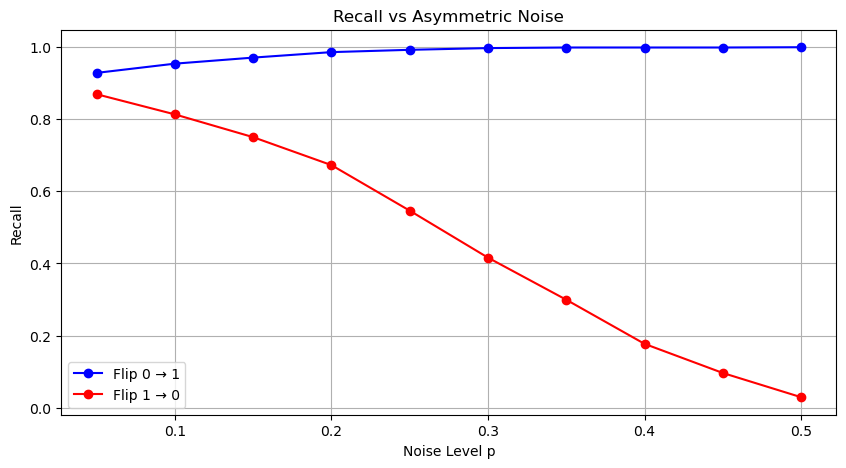

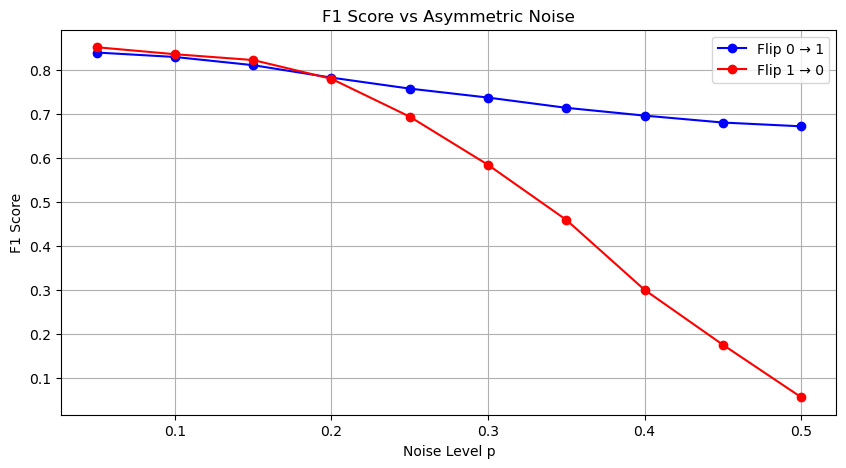

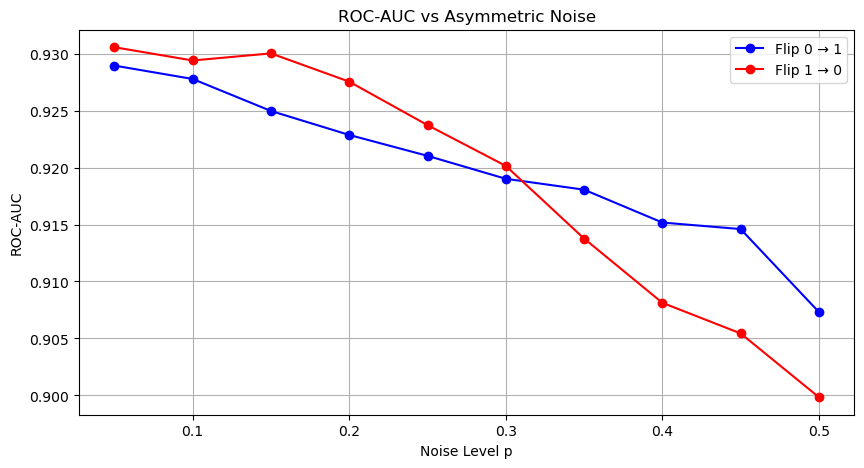

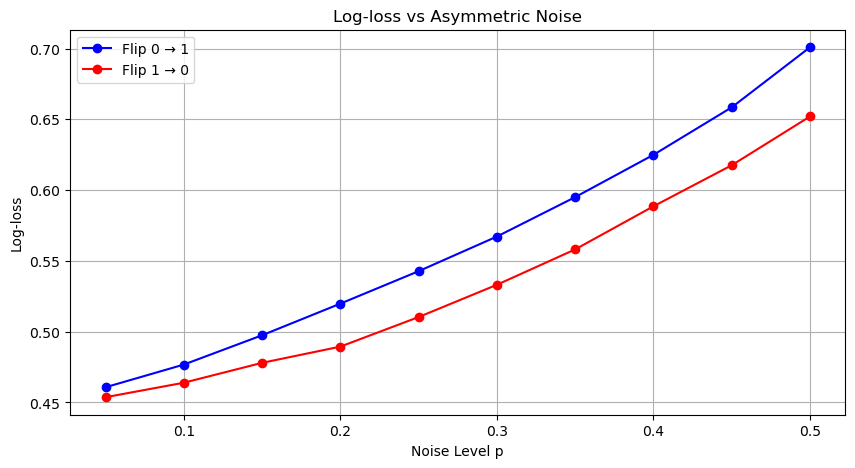

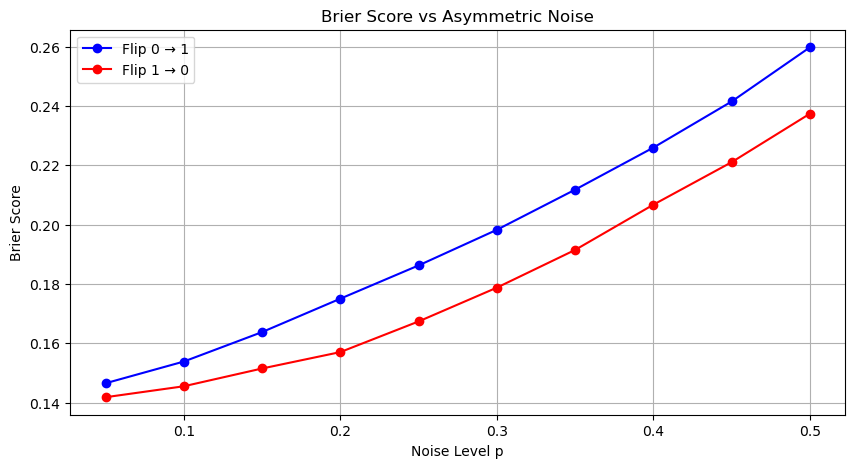

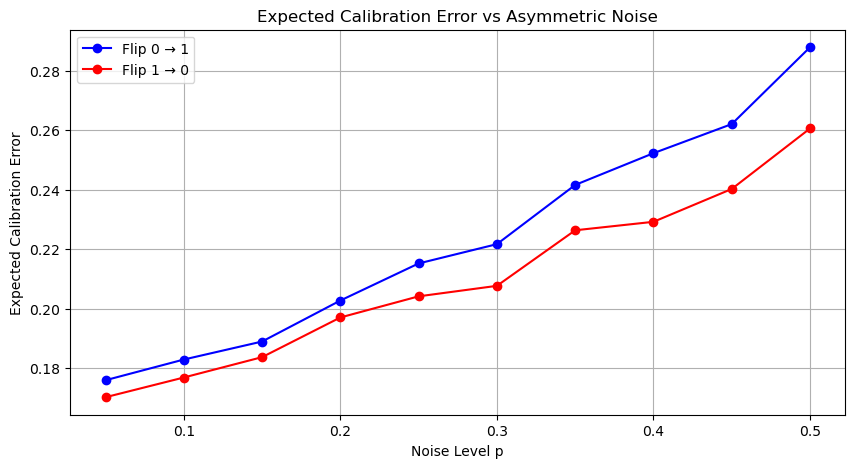

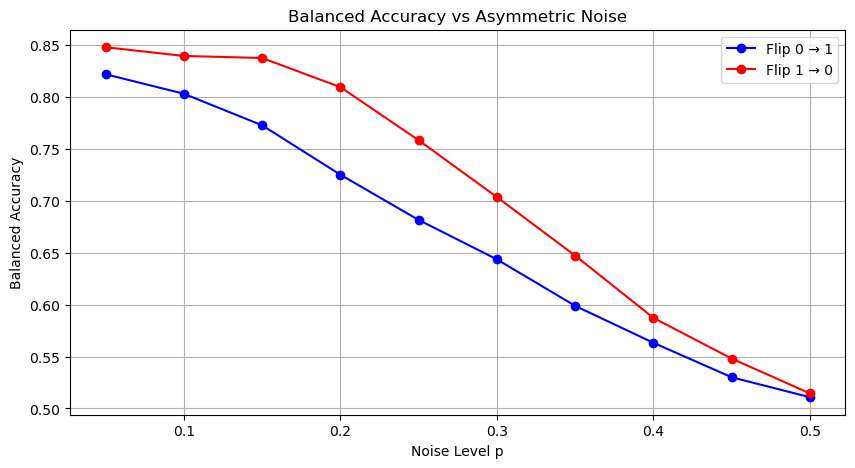

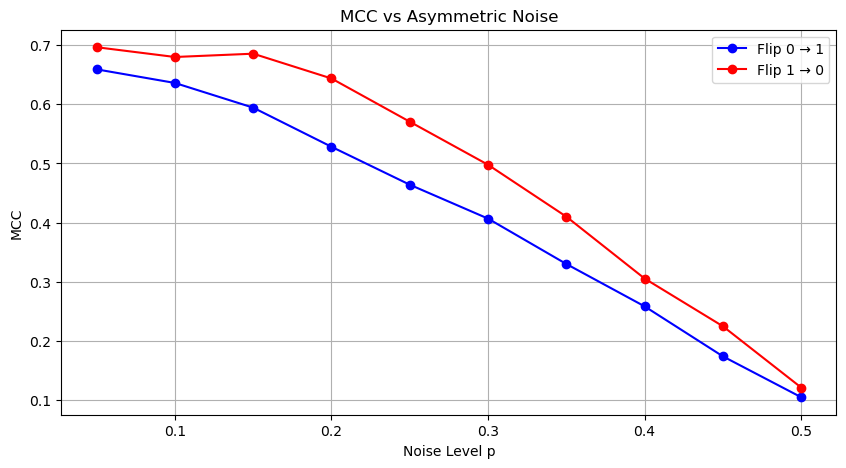

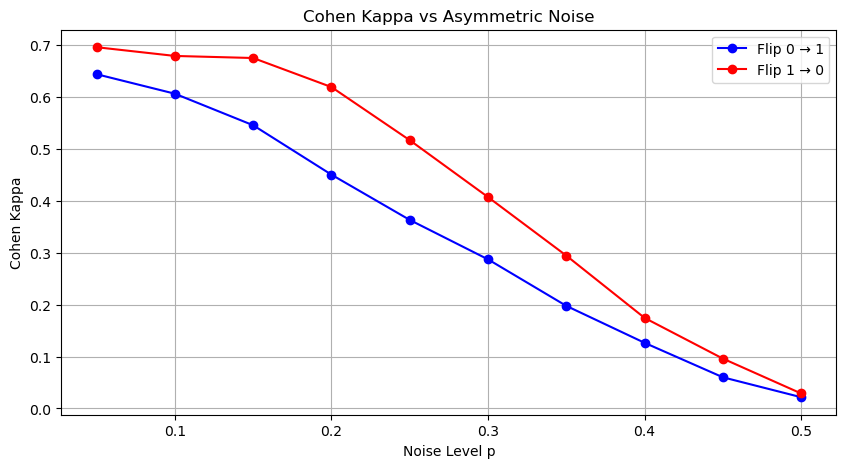

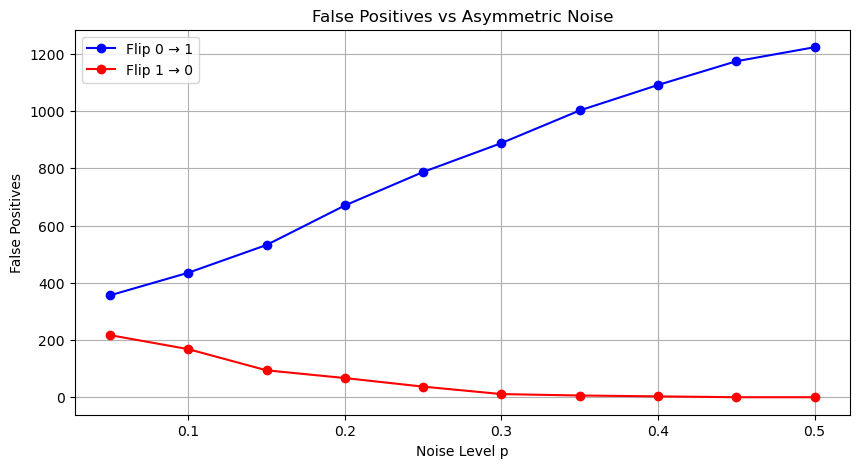

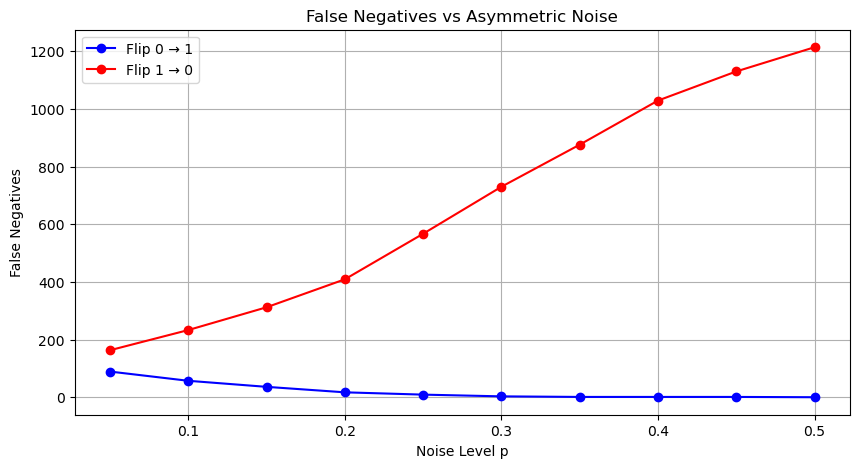

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    confusion_matrix
)

# -----------------------------------------------------------
# Asymmetric noise function
# -----------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = y.copy()
    idx = np.where(y == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy


# -----------------------------------------------------------
# Expected Calibration Error (ECE)
# -----------------------------------------------------------
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0
    for i in range(n_bins):
        idx = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.sum(idx) > 0:
            avg_conf = y_prob[idx].mean()
            avg_acc  = y_true[idx].mean()
            ece += (np.sum(idx) / len(y_prob)) * abs(avg_conf - avg_acc)
    return ece


# -----------------------------------------------------------
# Noise levels and flip directions
# -----------------------------------------------------------
noise_levels = np.arange(0.05, 0.55, 0.05)
flip_directions = [0, 1]      # 0→1 and 1→0


# -----------------------------------------------------------
# Storage: metrics per direction
# -----------------------------------------------------------
metrics = {
    0: {"acc": [], "prec": [], "rec": [], "f1": [], "auc": [],
        "logloss": [], "brier": [], "ece": [],
        "balacc": [], "mcc": [], "kappa": [],
        "fp": [], "fn": []},

    1: {"acc": [], "prec": [], "rec": [], "f1": [], "auc": [],
        "logloss": [], "brier": [], "ece": [],
        "balacc": [], "mcc": [], "kappa": [],
        "fp": [], "fn": []}
}


# -----------------------------------------------------------
# MAIN LOOP — Run for each flip direction AND noise level
# -----------------------------------------------------------
for class_to_flip in flip_directions:
    print(f"\n=======================")
    print(f"Testing flip direction: {class_to_flip} → {1 - class_to_flip}")
    print("=======================\n")

    for p in noise_levels:
        print(f"p = {p:.2f}")

        # Inject asymmetric noise in TRAIN only
        y_train_noisy = inject_asymmetric_noise(
            y_train.values, class_to_flip=class_to_flip, flip_fraction=p
        )

        # KNN training
        knn_noisy = KNeighborsClassifier(
            n_neighbors=best_k,
            metric="manhattan"
        )
        knn_noisy.fit(X_train_pca, y_train_noisy)

        # Predictions
        y_pred_noisy = knn_noisy.predict(X_test_pca)
        y_prob_noisy = knn_noisy.predict_proba(X_test_pca)[:, 1]

        # Metrics
        acc = accuracy_score(y_test, y_pred_noisy)
        prec = precision_score(y_test, y_pred_noisy)
        rec = recall_score(y_test, y_pred_noisy)
        f1 = f1_score(y_test, y_pred_noisy)
        auc = roc_auc_score(y_test, y_prob_noisy)

        ll = log_loss(y_test, y_prob_noisy)
        brier = brier_score_loss(y_test, y_prob_noisy)
        ece = compute_ece(y_test, y_prob_noisy)

        balacc = balanced_accuracy_score(y_test, y_pred_noisy)
        mcc = matthews_corrcoef(y_test, y_pred_noisy)
        kappa = cohen_kappa_score(y_test, y_pred_noisy)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_noisy).ravel()

        # Append to correct dict
        dir_metrics = metrics[class_to_flip]

        dir_metrics["acc"].append(acc)
        dir_metrics["prec"].append(prec)
        dir_metrics["rec"].append(rec)
        dir_metrics["f1"].append(f1)
        dir_metrics["auc"].append(auc)

        dir_metrics["logloss"].append(ll)
        dir_metrics["brier"].append(brier)
        dir_metrics["ece"].append(ece)

        dir_metrics["balacc"].append(balacc)
        dir_metrics["mcc"].append(mcc)
        dir_metrics["kappa"].append(kappa)

        dir_metrics["fp"].append(fp)
        dir_metrics["fn"].append(fn)

        print(f"  Accuracy={acc:.4f}, AUC={auc:.4f}, F1={f1:.4f}")
    print("\n")


# -----------------------------------------------------------
# PLOTTING FUNCTION FOR BOTH DIRECTIONS
# -----------------------------------------------------------
def compare_plot(metric_name, ylabel, color0="blue", color1="red"):
    plt.figure(figsize=(10,5))
    plt.plot(noise_levels, metrics[0][metric_name], marker="o", color=color0, label="Flip 0 → 1")
    plt.plot(noise_levels, metrics[1][metric_name], marker="o", color=color1, label="Flip 1 → 0")
    plt.title(f"{ylabel} vs Asymmetric Noise")
    plt.xlabel("Noise Level p")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()


# -----------------------------------------------------------
# PLOT ALL METRICS
# -----------------------------------------------------------
compare_plot("acc", "Accuracy")
compare_plot("prec", "Precision")
compare_plot("rec", "Recall")
compare_plot("f1", "F1 Score")
compare_plot("auc", "ROC-AUC")

compare_plot("logloss", "Log-loss")
compare_plot("brier", "Brier Score")
compare_plot("ece", "Expected Calibration Error")

compare_plot("balacc", "Balanced Accuracy")
compare_plot("mcc", "MCC")
compare_plot("kappa", "Cohen Kappa")

compare_plot("fp", "False Positives")
compare_plot("fn", "False Negatives")

# Noise 3 = Imputations

In [43]:
# ==========================================
# MISSING VALUE NOISE (RANDOM MISSINGNESS)
# ==========================================

import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def inject_missingness(X, missing_rate):
    """
    Randomly makes 'missing_rate' fraction of entries NaN.
    """
    X_noisy = X.copy()
    mask = np.random.rand(*X_noisy.shape) < missing_rate
    X_noisy[mask] = np.nan
    return X_noisy

# -----------------------------------------------------------
# Try missingness levels
# -----------------------------------------------------------
missing_levels = [0.05, 0.10, 0.20, 0.30]

results_missing = {}

for m in missing_levels:
    print(f"\n=== Missing Value Noise Level = {m} ===")

    # Inject noise into TRAIN ONLY
    X_train_missing = inject_missingness(X_train_pca.copy(), m)

    # Use simple imputer (mean)
    imputer = SimpleImputer(strategy="mean")
    X_train_imp = imputer.fit_transform(X_train_missing)
    X_test_imp  = imputer.transform(X_test_pca)

    # KNN training
    knn = KNeighborsClassifier(n_neighbors=best_k, metric="manhattan")
    knn.fit(X_train_imp, y_train)

    # Predictions
    y_pred = knn.predict(X_test_imp)
    y_prob = knn.predict_proba(X_test_imp)[:, 1]

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    results_missing[m] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

    print(results_missing[m])


=== Missing Value Noise Level = 0.05 ===
{'accuracy': 0.8332, 'precision': 0.7939308398023994, 'recall': 0.9, 'f1': 0.843644544431946, 'auc': 0.92802336}

=== Missing Value Noise Level = 0.1 ===
{'accuracy': 0.8404, 'precision': 0.8011323425336164, 'recall': 0.9056, 'f1': 0.8501689823507322, 'auc': 0.93004256}

=== Missing Value Noise Level = 0.2 ===
{'accuracy': 0.8332, 'precision': 0.789839944328462, 'recall': 0.908, 'f1': 0.8448083364346856, 'auc': 0.9279088}

=== Missing Value Noise Level = 0.3 ===
{'accuracy': 0.8304, 'precision': 0.7988422575976846, 'recall': 0.8832, 'f1': 0.8389057750759878, 'auc': 0.92015808}


# Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise)

In [44]:
# ================================================
# LABEL NOISE VIA CONFUSION MATRIX (TRANSITION MATRIX)
# ================================================

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    """
    eta_01 = P(0 -> 1)
    eta_10 = P(1 -> 0)
    """
    np.random.seed(random_state)
    y_noisy = y.copy()

    # Flip 0 → 1
    idx0 = np.where(y == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1

    # Flip 1 → 0
    idx1 = np.where(y == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0

    return y_noisy


# -----------------------------------------------------------
# Define 2D grid of noise (example)
# -----------------------------------------------------------
eta_pairs = [
    (0.1, 0.1),
    (0.2, 0.05),
    (0.05, 0.2),
    (0.3, 0.1),
]

results_confusion = {}

for eta_01, eta_10 in eta_pairs:
    print(f"\n=== Noise: 0→1={eta_01}, 1→0={eta_10} ===")

    # Add noise to TRAIN only
    y_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

    knn = KNeighborsClassifier(n_neighbors=best_k, metric="manhattan")
    knn.fit(X_train_pca, y_noisy)

    y_pred = knn.predict(X_test_pca)
    y_prob = knn.predict_proba(X_test_pca)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    results_confusion[(eta_01, eta_10)] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

    print(results_confusion[(eta_01, eta_10)])


=== Noise: 0→1=0.1, 1→0=0.1 ===
{'accuracy': 0.8396, 'precision': 0.8021352313167259, 'recall': 0.9016, 'f1': 0.8489642184557439, 'auc': 0.92371744}

=== Noise: 0→1=0.2, 1→0=0.05 ===
{'accuracy': 0.7524, 'precision': 0.6747922437673131, 'recall': 0.9744, 'f1': 0.7973813420621931, 'auc': 0.92038496}

=== Noise: 0→1=0.05, 1→0=0.2 ===
{'accuracy': 0.8104, 'precision': 0.8967280163599182, 'recall': 0.7016, 'f1': 0.7872531418312387, 'auc': 0.9210416}

=== Noise: 0→1=0.3, 1→0=0.1 ===
{'accuracy': 0.6812, 'precision': 0.6124069478908188, 'recall': 0.9872, 'f1': 0.755895865237366, 'auc': 0.90820512}


# Noise 5 = Neighborhood-Dependent Noise (Local Density Noise)

In [45]:
# ======================================================
# NEIGHBORHOOD-DEPENDENT NOISE (LOCAL DENSITY NOISE)
# ======================================================

from sklearn.neighbors import NearestNeighbors

def inject_neighborhood_noise(X, y, base_rate):
    """
    base_rate controls overall noise intensity.
    Local noise probability is proportional to distance from nearest neighbor.
    """
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    distances, _ = nbrs.kneighbors(X)
    
    # Distance to nearest neighbor (excluding itself)
    dist = distances[:, 1]

    # Normalize to [0,1]
    local_noise_prob = dist / dist.max()

    # Noise probability = base_rate * local_density_prob
    flip_prob = local_noise_prob * base_rate

    y_noisy = y.copy()
    for i in range(len(y)):
        if np.random.rand() < flip_prob[i]:
            y_noisy[i] = 1 - y_noisy[i]

    return y_noisy


# -----------------------------------------------------------
# Try several base noise rates
# -----------------------------------------------------------
base_rates = [0.05, 0.10, 0.20]

results_local = {}

for br in base_rates:
    print(f"\n=== Neighborhood Noise base_rate = {br} ===")

    y_noisy = inject_neighborhood_noise(X_train_pca, y_train.values, br)

    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=best_k, metric="manhattan")
    knn.fit(X_train_pca, y_noisy)

    y_pred = knn.predict(X_test_pca)
    y_prob = knn.predict_proba(X_test_pca)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    results_local[br] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

    print(results_local[br])


=== Neighborhood Noise base_rate = 0.05 ===
{'accuracy': 0.8372, 'precision': 0.7983014861995754, 'recall': 0.9024, 'f1': 0.8471648516710477, 'auc': 0.92868896}

=== Neighborhood Noise base_rate = 0.1 ===
{'accuracy': 0.8396, 'precision': 0.8025659301496793, 'recall': 0.9008, 'f1': 0.8488503580851866, 'auc': 0.92874976}

=== Neighborhood Noise base_rate = 0.2 ===
{'accuracy': 0.8392, 'precision': 0.801994301994302, 'recall': 0.9008, 'f1': 0.8485305199698568, 'auc': 0.9271158399999999}
